In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from scipy.special import logit, expit
if '..' not in sys.path:
   sys.path.append('..')
import importlib
from ehr2vec.time2event_tmle import estimation, simulation_r
importlib.reload(simulation_r)
importlib.reload(estimation)

from ehr2vec.time2event_tmle.estimation import (
    estimate_ps, full_IPCW, transform_data_for_model_estimation, fit_failure_model, fit_censoring_model)
from ehr2vec.time2event_tmle.simulation_r import (
    simulate_data, theoretical_survival_function)

### 1. Simulate data and compute theoretical survival curve and empirical survival curve

In [18]:
data = simulate_data(10000, censoring_kwargs={'scale':15, 'shape_multiplier': .5})
data = pd.DataFrame(data)
time_points = np.linspace(.1, 40, 200)
survival_curve_treated = theoretical_survival_function(time_points, data['X'], 1)

# simulate all under treatment/ no treatment to get the empirical survival curve
data_treated = simulate_data(100000, A=1)
survival_curve_untreated = theoretical_survival_function(time_points, data_treated['X'], 0)
data_untreated = simulate_data(100000, A=0)

### Compare the theoretical survival curve and empirical survival curve

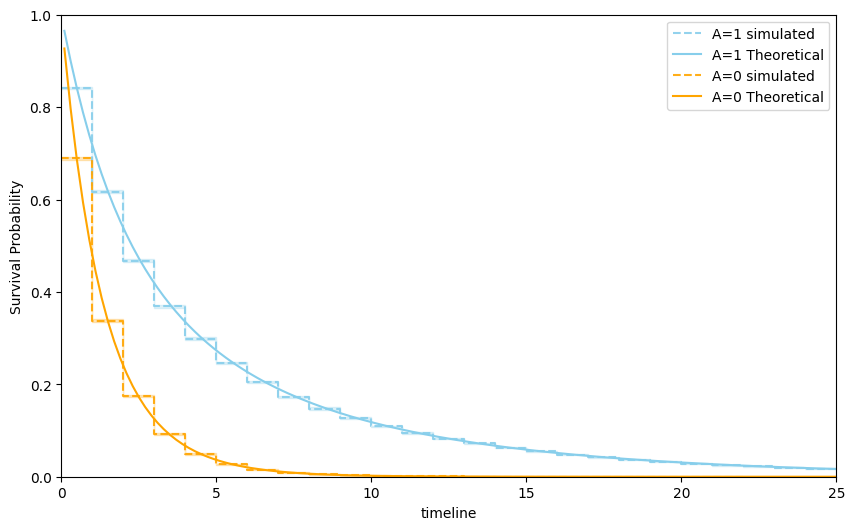

In [19]:
# make a Kaplan-Meier curve
fig, ax = plt.subplots(figsize=(10, 6))
# Treated
kmf = KaplanMeierFitter()
kmf.fit(data_treated['T_observed'], event_observed=data_treated['Y'], label='A=1 simulated')
kmf.plot(ax=ax, alpha=.9, linestyle='--', color='skyblue')
ax.plot(time_points, survival_curve_treated, label='A=1 Theoretical', color='skyblue')

# Untreated
kmf.fit(data_untreated['T_observed'], event_observed=data_untreated['Y'], label='A=0 simulated')
kmf.plot(ax=ax, alpha=.9, linestyle='--', color='orange')
ax.plot(time_points, survival_curve_untreated, label='A=0 Theoretical', color='orange')
ax.set_xlabel('timeline')
ax.set_ylabel('Survival Probability')
ax.set_xlim(0, 25)
ax.set_ylim(0, 1)
plt.legend()
plt.show()

## Estimate PS

In [20]:
data = estimate_ps(data)

## Estimate survival function for failure event $S_E(t|A,X)$
It is defined as:  
&nbsp;&nbsp;$S_E(t|A,X)=\Pi_{k=1}^{t}[1-\lambda_E(k|A,X)]\,,$  
where $\lambda_N(t|A,X)$ is the hazard function for failure event $E$ at time $t$ given $A$ and $X$, which can be computed as:    
&nbsp;&nbsp;$\lambda_E(t|A,X)=P[E(t)=1|\,A,\,X]\,,$  

In practice we restructure the data, to be able to to train one classifier which takes $t-1$, $A$ and $X$ and predicts whether the event $N$ will occur at time $t$.  
What we do is we construct, for each t, until the event or censoring occurs, a row with the following columns:
- label $E(t)$ which is the event indicator
- X
- A
- t  

Here is an example dataset:  
- T_observed = {2, 3, 5}
- E = {0, 1, 0}
- A = {0, 1, 0}
- X = {1, 2, 3}  
  
From that we can construct the classification dataset as follows:  
for patient 1:
- $Y_E = \{0, 0, 0\}$
- t = {0, 1, 2}
- A = {0, 0, 0}
- X = {1, 1, 1}
  
for patient 2:
- $Y_E = \{0, 0, 0, 1\}$
- t = {0, 1, 2, 3}
- A = {1, 1, 1, 1}
- X = {2, 2, 2, 2} ...


In [21]:
cls_data = transform_data_for_model_estimation(data)
# Step 2: Fit the failure model to estimate the survival curve
failure_model = fit_failure_model(cls_data)
cls_data.head()

,pid,t,A,X,Y_E,Y_C
0,0,0,0.0,0.561810,0,0
1,0,1,0.0,0.561810,0,0
2,0,2,0.0,0.561810,1,0
3,1,0,1.0,1.426071,1,0
4,2,0,1.0,1.097991,0,0


## Estimate censoring model $S_C(t|A,X)$   
Same as failure model but swap E and C.
Example with the previous data:
- T_observed = {2, 3, 5}
- E = {0, 1, 0}
- A = {0, 1, 0}
- X = {1, 2, 3}
for simpplicity we only write down the labels  
patient 1:
- $Y_C = \{0, 0, 1\}$  
patient 2:  
- $Y_C = \{0, 0, 0, 0\}$ (since event occurs)  
patient 3:
- $Y_C = \{0, 0, 0, 0, 0, 1\}$ 

In [22]:
censoring_model = fit_censoring_model(cls_data)

## IPCW  
The (plug-in) IPCW estimator of the survival function for the treated is defined as:  

$$
\hat{S}_{\text{IPCW}}(t) = \frac{1}{n}\sum_{i=1}^{n}\frac{I(\tilde{T}_{obs}>t,\,\Delta_i=1,\,A_i=1)}{S_C(\tilde{T}|X_i,\, A_i=1)g(X_i)}
$$

sidenote: For each $t$, we sum over patients who are still at risk, but have the event observed at some time. 

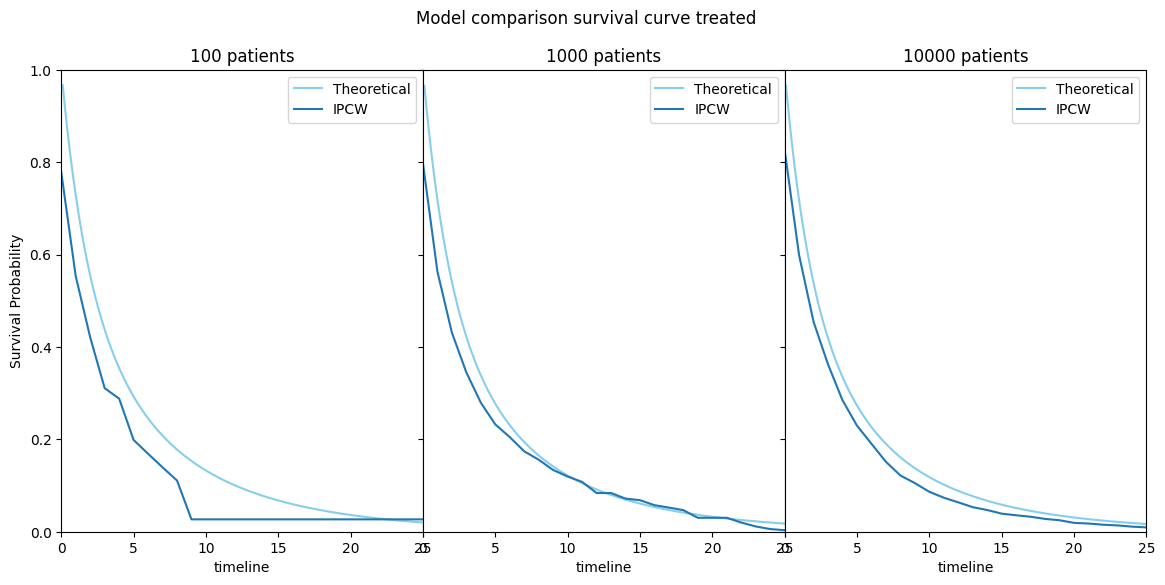

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
ax = ax.flatten()
for i, patient_num in enumerate([100, 1000, 10000]):
    data = simulate_data(patient_num, censoring_kwargs={'scale':15, 'shape_multiplier': .5})
    data = pd.DataFrame(data)

    time_points = np.linspace(.1, 30, 200)
    survival_curve_treated = theoretical_survival_function(time_points, data['X'], 1)
    
    ipcw_survival_curve, max_time = full_IPCW(data)
    # make a Kaplan-Meier curve
    # Treated
    ax[i].plot(time_points, survival_curve_treated, label='Theoretical', color='skyblue')
    ax[i].plot(np.arange(0, max_time-1), ipcw_survival_curve[:max_time], label='IPCW')
    # Untreated
    ax[i].set_xlabel('timeline')
    if i == 0:
        ax[i].set_ylabel('Survival Probability')
    if i!=0:
        ax[i].set_yticklabels([])
    ax[i].set_xlim(0, 25)
    ax[i].set_ylim(0, 1)
    ax[i].set_title(f'{patient_num} patients')
    ax[i].legend()
fig.subplots_adjust(wspace=.0)
fig.suptitle("Model comparison survival curve treated")
fig.savefig('IPCW_model_comparison_survival_curve_treated.png')
plt.show()

## Targeted TMLE

In [24]:
data = pd.DataFrame(simulate_data(10000, censoring_kwargs={'scale':15, 'shape_multiplier': .5}))
data = estimate_ps(data)
cls_data = transform_data_for_model_estimation(data)
failure_model = fit_failure_model(cls_data)
censoring_model = fit_censoring_model(cls_data)

In [25]:
from sklearn.linear_model import LogisticRegression
import tqdm

"""Here we follow the steps from the supplementary material of ONe step TMLE for time2event outcomes."""

def compute_clever_covariate(patient, cls_patient, t, k, A):
    """
    Compute clever covariate, see 
    Application of Time-to-Event Methods in the Assessment of Safety in Clinical Trials, Moore et al. 2009
    page 5+6

    Args:
        patient (pd.Series): The patient data.
        cls_patient (pd.DataFrame): The temporal patient data
        t (int): The time point to estimate the survival probability.
        k (int): Second time index running to T_observed.
        A (int): Which curve to estimate, 0 or 1.
    """
    if patient['A'] != A:
        return 0
    
    if k>t:
        return 0
    if patient['A'] == 1:
        g = patient['propensity']
    else:
        g = 1 - patient['propensity']

    C_surv_prob_k_ = cls_patient.loc[cls_patient['t'] == k, 'S_C'].values[0]
    E_surv_t = cls_patient.loc[cls_patient['t'] == t, 'S_E'].values[0]
    E_surv_k = cls_patient.loc[cls_patient['t'] == k, 'S_E'].values[0]

    clever_covariate = - E_surv_t/ (E_surv_k * C_surv_prob_k_ * g) 
    return float(clever_covariate)

def compute_lambda_E(patient, t, failure_model, A):
    lambda_input = pd.DataFrame({'t':[t], 'A':[A], 'X':[float(patient['X'])]})
    lambda_E = failure_model.predict_proba(lambda_input)[:, 1]
    return float(lambda_E)

def check_if_event_happened_for_positive_patient(patient, k):
    if ((patient['T_observed'] == k) and (patient['Y']==1)):
        return 1
    return 0

def estimate_survival_probability_for_all_t(cls_data: pd.DataFrame, name: str=None, failure_model: object=None, failure_column: str=None )->pd.DataFrame:
    """
    Estimate the survival probability for each entry in the dataframe.
    Args:
        data (pd.DataFrame): The input data containing t, A, X.
        model (object): The fitted censoring/failure model.
    
    Returns:
        cls_data: data with an additional columns 'S_{name}' surival probability and 'F_{name}' failure_probability.
    """
    cls_data = cls_data.copy()
    if failure_model is None:
        if failure_column is None:
            raise ValueError("Please provide a failure column name.")
    else:                
        if name is None:
            raise ValueError("Please provide a column name e.g. E or C.")
        failure_column = f'F_{name}'
        cls_data.loc[:, failure_column] = failure_model.predict_proba(cls_data[['t', 'A', 'X']])[:, 1]
    cls_data.loc[:, f'S_{name}'] = (1-cls_data[failure_column]).groupby(cls_data['pid']).transform('cumprod')
    return cls_data

def compute_TMLE(data: pd.DataFrame, cls_data: pd.DataFrame, failure_model: object, censoring_model: object, treatment:int):
    cls_data = estimate_survival_probability_for_all_t(cls_data, 'E', failure_model, )
    cls_data = estimate_survival_probability_for_all_t(cls_data, 'C', censoring_model, )

    Psi = []
    for t in range(1, 10): # set to t_max for the full range
        
        print('\n t', t)
        # print('t', t)
        j = 0 # iterations
        epsilon = 1
        while (epsilon>1e-2) and (j<10):
            h_arr, N_arr, lambda_E_arr, indices = [], [], [], []
            
            #  we will concatenate along i and k to form a vector which we run regression on
            for i, patient in tqdm.tqdm(data.iterrows(), total=len(data)):#
                if t>patient['T_observed']:
                    continue
                #print('x', end='')
                #print('T_observed', patient['T_observed'], end=' ')
                
                cls_patient = cls_data[cls_data.pid == i]
                
                for k in range(0, int(patient['T_observed'])+1):
                    
                    N = check_if_event_happened_for_positive_patient(patient, k)
                    # ! TODO: we can add ps to cls_data or simply pass the ps model for consistency.
                    ht = compute_clever_covariate(patient, cls_patient, t, k, A=treatment) 
                    lambda_E = compute_lambda_E(patient, k, failure_model, A=treatment)

                    h_arr.append(ht)
                    N_arr.append(N)
                    lambda_E_arr.append(lambda_E)
                    indices.append(int(cls_patient[cls_patient['t'] == k].index[0]))
                                
            h_arr, N_arr, lambda_E_arr = np.array(h_arr), np.array(N_arr), np.array(lambda_E_arr)

            # get epsilon by running a logisitc regression on logit(N) = logit(lambda) + epsilon*h
            logit_lambda = logit(lambda_E_arr.clip(1e-10, 1 - 1e-10))  # Avoid log(0) by clipping values
            # Prepare the data for logistic regression
            X = pd.DataFrame({
                'logit_lambda': logit_lambda,
                'h': h_arr
            })
  
            logistic_regression = LogisticRegression(fit_intercept=False, solver='lbfgs')  # No intercept as we model logit(N) = logit(lambda) + epsilon*h
            logistic_regression.fit(X, N_arr)
            print(X, N_arr)
            # Get the epsilon coefficient
            epsilon = logistic_regression.coef_[0][1]
            new_lambda = expit(logit_lambda + epsilon * h_arr)
            
            cls_data.loc[indices, 'F_E'] = new_lambda
            cls_data = estimate_survival_probability_for_all_t(cls_data, 'E', failure_column='F_E') 
                
            print('epsilon:', round(epsilon,3), end=' ')
            
            j+=1 # increase the iteration counter
        Psi.append(cls_data.loc[cls_data['t'] == t, 'S_E'].mean())
    return np.array(Psi)
            

In [9]:
data_small = data.iloc[:500]
cls_data_small = cls_data[cls_data.pid.isin(data_small.index)]

compute_TMLE(data_small, cls_data_small, failure_model, censoring_model, treatment=1)

NameError: name 'compute_TMLE' is not defined